In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from wrappers import make_atari_env
from replay_memory import ReplayBuffer
from utils_modif import train_modif, test_modif
from Param_modif import *
import gym
import random
import numpy as np

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
'''Sets device to CPU or GPU'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
'''We can create our own network classes using the nn.Module'''
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        '''Set number of input and output neurons'''
        self.input_shape = input_shape
        self.num_actions = num_actions
        '''We use the sequential method similar to Keras
           We can also set two variables: conv and fc. This allows us to easily
           our feature extractor (CNN) from our classifier (FC).'''
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        '''We need to define a forward method for predictions.
           This method uses our self.conv network, flattens using x.view
           and then outputs the final prediction using self.fc'''
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def act(self, state, epsilon, device=device):
        '''Epsilon greedy policy implementation'''
        if random.random() > epsilon:
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(self.num_actions)
        return action

# Pong!
Now we are going to play some pong

In [6]:
# We can create our Pong Environment and view the actionspace
env_id = "ALE/Pong-ram-v5"
env = make_atari_env(env_id)
print(env.action_space)
env.unwrapped.get_action_meanings()

Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [8]:
'''This RL approach uses two models. We did not discuss this in class,
   but a two model approach is typical'''
current_model = DQN(env.observation_space.shape, env.action_space.n).to(device) # We tell pytorch where to run our model via .to    
target_model = DQN(env.observation_space.shape, env.action_space.n).to(device)    

'''Set the optimizer and Replay Buffer'''
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

'''Load my saved model'''
current_model.load_state_dict(torch.load('models_modified/PongNoFrameskip-v4_awesome.pth', map_location=torch.device('cpu')))
target_model.load_state_dict(torch.load('models_modified/PongNoFrameskip-v4_awesome.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [7]:
'''Play a (hopefully) perfect game of pong.'''
model = current_model # set what model to use
#env.viewer = None     # Reset the environment viewer
state, _ = env.reset()   # Restart pong
episode_reward = 0.0  # Reset Reward
while True:
    action = model.act(state, 0, device) # Determine what action to take
    next_state, reward, done,_, _ = env.step(action) # Step through the env
    #env.render() # Render frame
    episode_reward += reward # Calculate total reward
    state = next_state # Next state
    if done:
        print(f"Finished Episode with reward {episode_reward}")
        break

env.close()  # Close the environment

'''Note: This will crash your kernel when the game ends... '''

Finished Episode with reward 20.0


'Note: '

# Reward Shaping
In order to look at rewards, we are going to use a wrapper to change Pong's rewards.

In [7]:
'''Gym.RewardWrapper overwrites an environments reward function'''

'''Change the reward function below so that the perfect agent learns how to lose'''
class StupidRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Change reward function here"""
        
        return reward

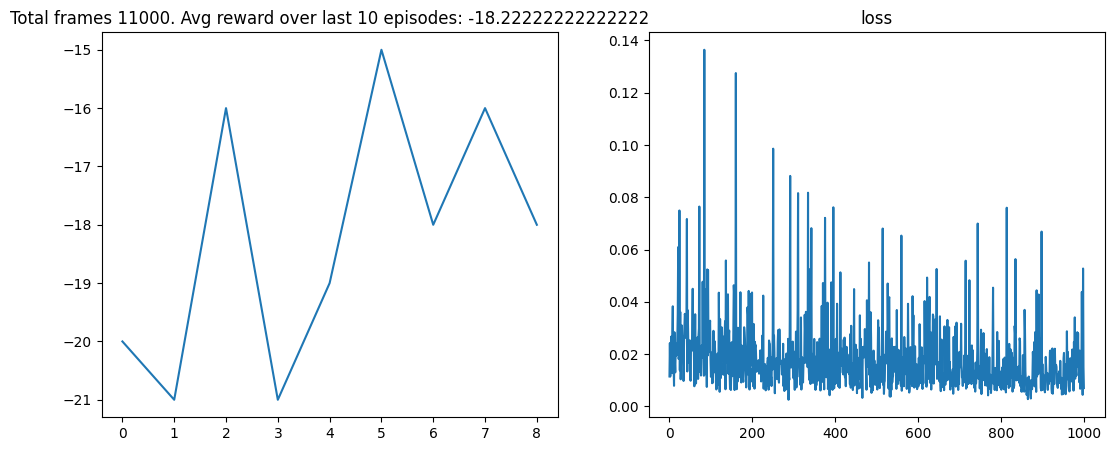

In [ ]:
'''Now we can wrap the environment with our reward function'''
env = make_atari_env(env_id, render_mode='rgb_array')
'''Your code here'''

'''Stop coding here'''
replay_buffer = ReplayBuffer(MEMORY_SIZE) # reset the replay buffer
train_modif(env, current_model,target_model, optimizer, replay_buffer, device) # train for 10 epochs
env.close()

In [ ]:
'''Now we can view the new agent'''
env = make_atari_env(env_id)
model = current_model
env.viewer = None
state, info = env.reset()
episode_reward = 0.0
while True:
    action = model.act(state, 0, device)
    next_state, reward, done, _, info = env.step(action)
    episode_reward += reward
    state = next_state
    if done:
        print(f"Finished Episode with reward {episode_reward}")
        break

env.close()  

# Random Agent 
In the cell below, write code that has your agent take random actions. You are welcome to use the code above and adapt it.

# Questions

1. What is the DQN architechture?
2. What does each output neuron represent?
3. Explain what a replay buffer is (you can google this).
4. Explain the behavior of the perfect agent?.
5. What the environments reward function before you changed it (you may need to look at the documentation)?
6. Explain how you changed the reward function to get the agent to lose.